# ISPR - Midterm 3: Assignment 2
Implement your own convolutional network, deciding how many layers, the type of layers and how they are interleaved, the type of pooling, the use of residual connections, etc. Discuss why you made each choice a provide performance results of your CNN on CIFAR-10.

Now that your network is trained, you might try an adversaria attack to it. Try the simple Fast Gradient Sign method, generating one (or more) adversarial examples starting from one (or more) CIFAR-10 test images. It is up to you to decide if you want to implement the attack on your own or use one of the available libraries (e.g. foolbox,  CleverHans, ...). Display the original image, the adversarial noise and the final adversarial example.

## 1 - Setup Operations

### 1.1 - Import Libraries

In [1]:
# Core libraries
import math
import random
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt 

import tensorflow as tf
import tensorflow.experimental.numpy as tnp
tnp.experimental_enable_numpy_behavior()

import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import InputLayer, Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense
from keras.layers import Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers, optimizers
from keras.utils import np_utils

from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent
from cleverhans.tf2.attacks.carlini_wagner_l2 import carlini_wagner_l2

In [2]:
print(tf.__version__)
print(tf.config.list_physical_devices('CPU'))
print(tf.config.list_physical_devices('GPU'))

2.5.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 1.2 - Dataset Loading

In [3]:
def load_data():
    # load dataset
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    
    # one hot encode target values
    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)
    
    # casting pixel values as floats
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    
    return x_train, y_train, x_test, y_test 

In [4]:
print("- Loading the Dataset")
x_train, y_train, x_test, y_test = load_data()

- Loading the Dataset


### 1.3 - Image Preprocessing

In [5]:
# scale pixels
def scale_pixels(x_train, x_test, debug=False):
    # calculate global mean and standard deviation
    mean = np.mean(x_train,axis=(0,1,2,3))
    std = np.std(x_train,axis=(0,1,2,3))
    
    # Debugging
    if debug == True:
        print('Mean: %.3f, Standard Deviation: %.3f' % (mean, std))
    
    # Apply global standardization (z-score)
    x_train = (x_train-mean)/(std+1e-7)
    x_test = (x_test-mean)/(std+1e-7)
  
    # clip pixel values to [-1,1]
    x_train = np.clip(x_train, -1.0, 1.0)
    x_test = np.clip(x_test, -1.0, 1.0)
    
    # shift from [-1,1] to [0,1] with 0.5 mean
    x_train = (x_train + 1.0) / 2.0
    x_test = (x_test + 1.0) / 2.0
    
    # Debugging
    if debug == True:
        print('Mean: %.3f, Standard Deviation: %.3f' % (x_train.mean(), x_train.std()))
        print('Min: %.3f, Max: %.3f' % (x_train.min(), x_train.max()))
    
    return x_train, x_test

In [6]:
print("- Applying Prepocessing to the images")
x_train, x_test = scale_pixels(x_train, x_test)

- Applying Prepocessing to the images


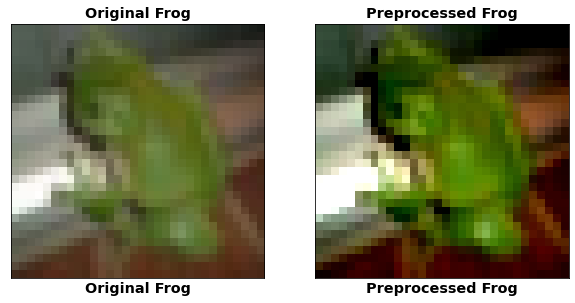

In [7]:
x_train_prova, y_train_prova, x_test_prova, y_test_prova = load_data()
frog_prova = x_test_prova[7] / 255
x_train_prova, x_test_prova= scale_pixels(x_train_prova, x_test_prova)
frog_aug_prova = x_test_prova[7]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.imshow(frog_prova)
ax1.set_title("Original Frog", fontsize="x-large", fontweight='bold')
ax1.set_xlabel("Original Frog", fontsize="x-large", fontweight='bold')
ax1.set_xticks([])
ax1.set_yticks([])
ax2.imshow(frog_aug_prova)
ax2.set_title("Preprocessed Frog", fontsize="x-large", fontweight='bold')
ax2.set_xlabel("Preprocessed Frog", fontsize="x-large", fontweight='bold')
ax2.set_xticks([])
ax2.set_yticks([])
plt.show()

### 1.4 - Data Augmentation

In [8]:
#data augmentation
def generate_data(x_train, y_train, batch_size=64, debug=False):
    datagen = ImageDataGenerator(rotation_range=15, 
                                 width_shift_range=0.1, 
                                 height_shift_range=0.1, 
                                 horizontal_flip=True)

    # prepare iterators
    datagen.fit(x_train)
    it_train = datagen.flow(x_train, y_train, batch_size=batch_size)
    
    steps = int(x_train.shape[0] / batch_size)
    
    # Debugging 
    if debug == True:
        print("Training samples: " + str(x_train.shape[0]))
        print("Steps_per_epoch: " + str(steps))

    return it_train, steps

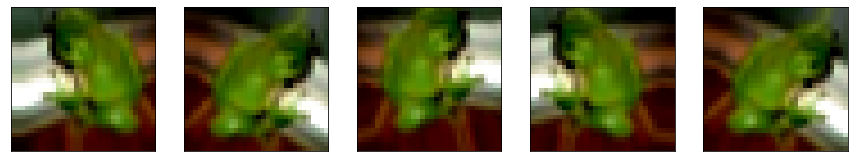

In [9]:
image = x_test[7]
datagen = ImageDataGenerator(rotation_range=15, 
                                 width_shift_range=0.1, 
                                 height_shift_range=0.1, 
                                 horizontal_flip=True)
fig, axs = plt.subplots(1, 5, figsize=(15, 15))
for i in range(5):
    axs[i].imshow(datagen.random_transform(image))
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    

## 2 - Convolutional Neural Network

### 2.1 - Model Definition

In [10]:
# define cnn model
def define_model(input_shape=(32, 32, 3), 
                 num_classes=10, 
                 baseMapNum=32, 
                 activation=tf.nn.elu,
                 pooling=MaxPooling2D(pool_size=(2, 2)),
                 incremental_dropout=False
                ):
    
    img_size = input_shape[0]
    log_resolution = int(round(math.log(img_size) / math.log(2)))
    
    conv_args = dict(activation=activation, kernel_size=3, padding="same", kernel_regularizer=regularizers.l2(1e-4), kernel_initializer='he_uniform')
    model = Sequential()
    model.add(InputLayer(input_shape=input_shape))

    # VGG-Style blocks
    for i in range(log_resolution - 2):         
        model.add(Conv2D(baseMapNum << i, **conv_args))
        model.add(BatchNormalization())
        model.add(Conv2D(baseMapNum << i, **conv_args))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2))) # fix this, it surpasses the function's parameter
        
        if incremental_dropout == True:
            model.add(Dropout(0.2 + 0.1*i))
        else:
            model.add(Dropout(0.2))
     
    # Flattening Layer
    model.add(Flatten())

    # Adding the first fully connected layer
    model.add(Dense(units=64, activation=activation))
    
    # Output Layer
    model.add(Dense(units=num_classes, activation="softmax"))
    
    model.summary()
    
    return model

### 2.2 - Model Training

In [11]:
#training
def train_model(model, 
                it_train, 
                x_test, 
                y_test, 
                steps, 
                epochs_per_phase=10, 
                train_schedule=[2,2,2], 
                start_lr=0.001,
                verbose=1,
                save=False,
                model_name=None
               ):
    
    loss_object = "categorical_crossentropy"
    train_acc = "accuracy"
    
    for i in range(len(train_schedule)):
        learning_rate = start_lr / (2**i)
        phase_len = train_schedule[i]
        
        if verbose == 1:
            print("\nPhase " + str(i+1) + " - Learning rate: " + str(learning_rate))
            
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate, decay=1e-6)
        model.compile(optimizer=optimizer, loss=loss_object, metrics=[train_acc])
        history = model.fit(it_train, steps_per_epoch=steps, epochs=phase_len*epochs_per_phase, validation_data=(x_test,y_test), verbose=verbose)
    
    if save == True:
        file_name = "models/" + model_name
        model.save(file_name, include_optimizer=True)
    
    return history

### 2.3 - Fitting the process in a single function

In [12]:
def get_model(model_name, epochs_per_phase=10, train_schedule=[2,2,2], debug=False, load=False, save=True):
    
    if load == True:    
        # Load Model
        if debug==True:
            print("\n- Loading the Model: " + "models/" + model_name)
        model = keras.models.load_model("models/" + model_name)
    
    else:
         # load Dataset 
        if debug==True:
            print("\n- Loading the Dataset")
        x_train, y_train, x_test, y_test = load_data()

        # Apply Preprocessing 
        if debug==True:
            print("\n- Applying Prepocessing to the images")
        x_train, x_test = scale_pixels(x_train, x_test, debug=debug)
        
        # Define Model
        if debug==True:
            print("\n- Defining the Model")
        model = define_model()
        
        # Data Augmentation
        if debug==True:
            print("\n- Performing Data Augmentation")
        it_train, steps = generate_data(x_train, y_train, debug=debug)

        # Train Model
        if debug==True:
            print("\n- Training the Model")
        history = train_model(model, it_train, x_test, y_test, steps, epochs_per_phase=epochs_per_phase, train_schedule=train_schedule, save=save, model_name=model_name)
    
    return model

In [13]:
# model = get_model(model_name="elu_3x20", save=True, debug=True)
model = get_model(model_name="rms_elu_3x20", load=True)

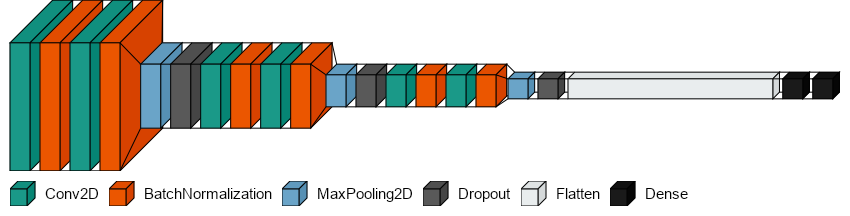

In [89]:
import visualkeras
from collections import defaultdict
from PIL import ImageFont

font = ImageFont.truetype("arial.ttf", 15)

color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = '#1a9988'
color_map[BatchNormalization]['fill'] = '#eb5600'
color_map[Dropout]['fill'] = '#595959'
color_map[MaxPooling2D]['fill'] = '#6aa4c8'
color_map[Dense]['fill'] = '#1a1a1a'
color_map[Flatten]['fill'] = '#e9edee'


#visualkeras.layered_view(model, color_map=color_map)


#visualkeras.layered_view(model, legend=True, font=font, color_map=color_map).show() # display using your system viewer
visualkeras.layered_view(model, to_file='output.png', legend=True, font=font, color_map=color_map) # write to disk
# visualkeras.layered_view(model, to_file='output.png').show() # write and show

# visualkeras.layered_view(model)

### 2.4 - Model Evaluation

#### 2.4.1 - Evaluation on (clean) test set

In [12]:
# Evaluate Model
test_accuracy = model.evaluate(x_test, y_test, batch_size=64, verbose=1)[1]
print("\nAccuracy on test set: " +  '> %.3f' % (test_accuracy)) 

157/157 [==============================] - 17s 8ms/step - loss: 0.5533 - accuracy: 0.8586

Accuracy on test set: > 0.859


#### 2.4.2 - Testing predictions for single (clean) images

In [19]:
def predict_class(model, image, show=True):
    class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
    
    if len(image.shape) != 4:
        plot_image = image
        reshaped_image = image.reshape(-1, 32, 32, 3)
    else:
        reshaped_image = image
        plot_image = image.reshape(32,32,3)
        
    pred_results = model.predict(reshaped_image)[0]
    max_confidence = max(pred_results)
    image_class_id = np.where(pred_results == max_confidence)[0][0]
    
    class_name = class_names[image_class_id]
    pred_confidence = round(max_confidence * 100.0, 2)
    
    if show == True:
        plt.imshow(plot_image)
        plt.title("Original Image Classification")
        plt.xlabel(class_name + ": " + str(pred_confidence))
        plt.xticks([])
        plt.yticks([])
        plt.show()
        
    else:
        return plot_image, class_name, pred_confidence

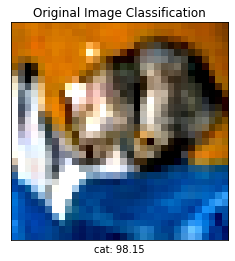

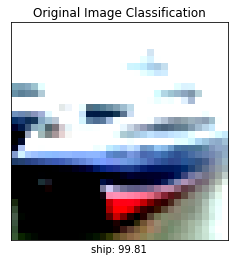

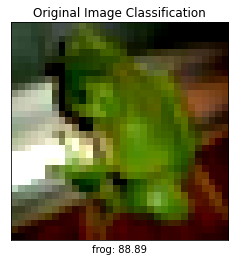

In [14]:
for i in [0, 1, 7]:
    predict_class(model, x_test[i])

## 3 - Adversarial Attack with Fast Gradient Method

In [20]:
def fgm_comparison(model, clean_image, eps=0.05, norm=np.inf, show=True, save=False):
    
    clean_image, clean_image_class, clean_image_confidence = predict_class(model, clean_image, show=False)
    
    adv_example = fast_gradient_method(model, clean_image.reshape(-1, 32, 32, 3), eps, norm)
    adv_example_image, adv_example_class, adv_example_confidence = predict_class(model, adv_example, show=False)
    adv_example_image = adv_example_image.clip(0.,1)
    
    adv_noise = (adv_example_image - clean_image)* 0.5 + 0.5 
    
    if norm == np.inf:
        norm = "inf"
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 10))
    fig.suptitle("Fast Gradient Method (eps=" + str(eps) + ", norm=" + str(norm) + ")", y=0.66, fontsize="x-large", ha="center")
    
    ax1.imshow(clean_image)
    ax1.set_title("Original Image Classification")
    ax1.set_xlabel(clean_image_class + ": " + str(clean_image_confidence))
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    ax2.imshow(adv_noise)
    ax2.set_title("Adversarial Noise")
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    ax3.imshow(adv_example_image)
    ax3.set_title("Adversarial Example")
    ax3.set_xlabel(adv_example_class + ": " + str(adv_example_confidence))
    ax3.set_xticks([])
    ax3.set_yticks([])
    
    if save == True:
        if norm == np.inf:
            image_name = clean_image_class + "_inf_" + str(eps) + ".png"
        else:
            image_name = clean_image_class + "_" + str(norm) + "_" + str(eps) + ".png"
        plt.savefig('images/' + image_name)
        plt.close()
     
    if show == True:
        plt.show() 

### 3.1 - Testing on single images for fixed epsilon (0.05)

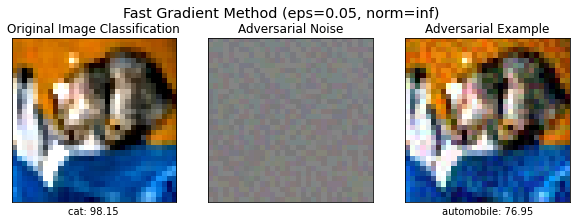

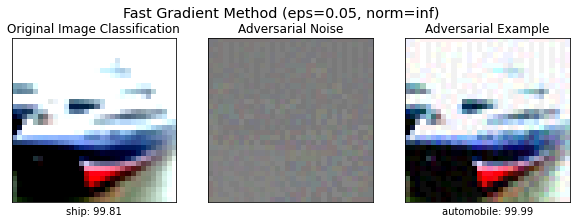

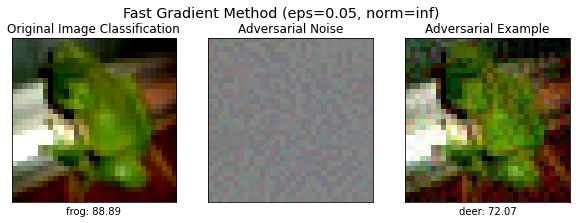

In [21]:
for i in [0, 1, 7]:
    fgm_comparison(model, x_test[i], eps=0.05, norm=np.inf)

### 3.2 - Testing on single images for differing values of epsilon

#### 3.2.1 - Frog test

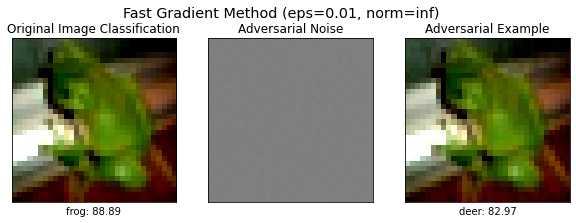

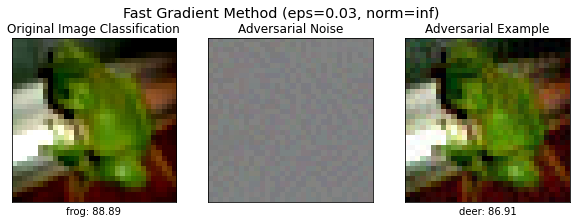

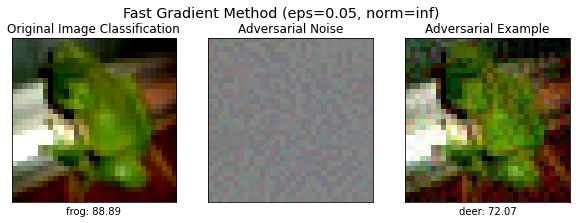

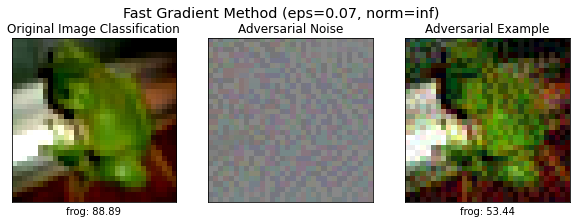

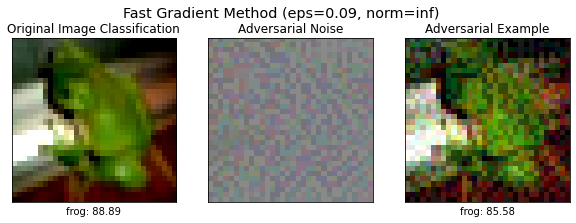

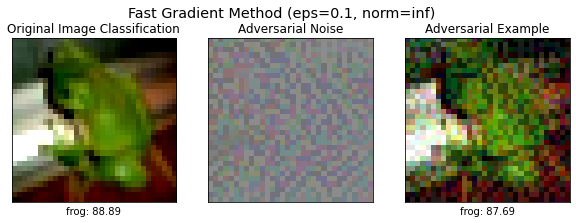

In [22]:
frog_image = x_test[7]
epsilons = [0.01, 0.03, 0.05, 0.07, 0.09, 0.1]
for eps in epsilons:
    fgm_comparison(model, frog_image, eps)

#### 3.2.2 - Boat test

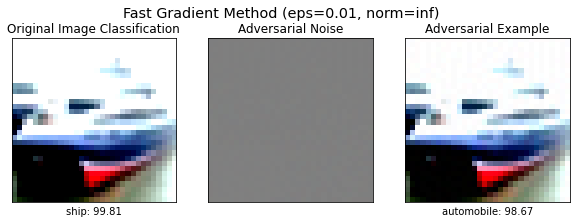

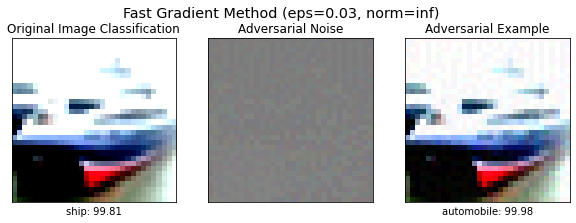

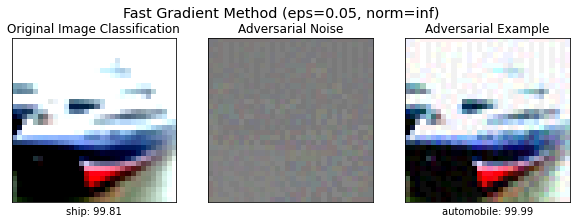

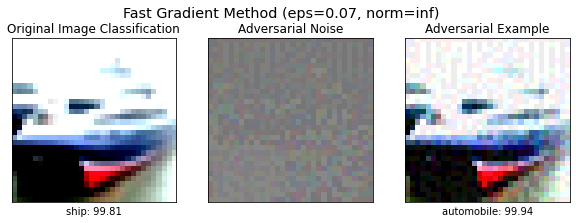

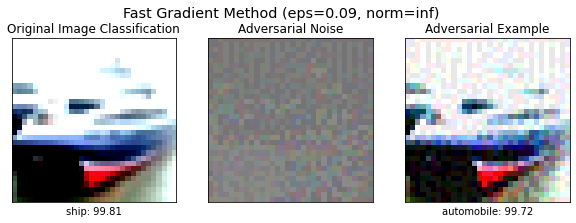

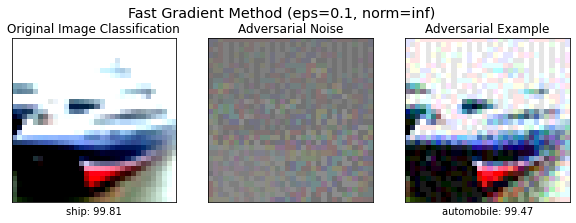

In [18]:
boat_image = x_test[1]
epsilons = [0.01, 0.03, 0.05, 0.07, 0.09, 0.1]
for eps in epsilons:
    fgm_comparison(model, boat_image, eps)

#### 3.2.3 - Save images for differing epsilons and norms

In [23]:
def fgm_PNG_per_GIF(model, clean_image, eps=0.05, norm=np.inf):
    
    clean_image, clean_image_class, clean_image_confidence = predict_class(model, clean_image, show=False)
    
    adv_example = fast_gradient_method(model, clean_image.reshape(-1, 32, 32, 3), eps, norm)
    adv_example_image, adv_example_class, adv_example_confidence = predict_class(model, adv_example, show=False)
    adv_example_image = adv_example_image.clip(0.,1)
    
    if adv_example_class != clean_image_class:
        label_color = "red"
    elif adv_example_confidence < clean_image_confidence:
        label_color = "orange"
    else:
        label_color = "green"
    
    adv_noise = (adv_example_image - clean_image)* 0.5 + 0.5 
    
    if norm == np.inf:
        text_norm = "Infinity "
    else:
        text_norm = norm
    
    fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(10, 10))
    #fig.suptitle("FGM: eps = " + str(eps) + ", norm = " + str(norm), y=0.96, fontsize="x-large", ha="center", fontweight='bold')
    
    ax2.imshow(adv_noise)
    ax2.set_title("Adversarial Noise", fontsize="x-large", fontweight='bold')
    ax2.set_xlabel("FGM (" + str(text_norm) + " Norm): eps = " + str(eps), fontsize="x-large", fontweight='bold')
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    ax3.imshow(adv_example_image)
    ax3.set_title("Adversarial Example", fontsize="x-large", fontweight='bold')
    ax3.set_xlabel(adv_example_class + ": " + str(adv_example_confidence), fontsize="x-large", c=label_color, fontweight='bold')
    ax3.set_xticks([])
    ax3.set_yticks([])

    if norm == np.inf:
        image_name = clean_image_class + "_inf_" + str(eps) + ".png"
    else:
        image_name = clean_image_class + "_" + str(norm) + "_" + str(eps) + ".png"
    plt.savefig('images/' + image_name)
    plt.close()

In [24]:
def fgm_GIF(model, clean_image, norm, image_name="image", eps_start=0.001, eps_end=0.2, eps_num=100):
    epsilons = list(np.linspace(eps_start, eps_end, num=eps_num))
    epsilons.insert(0,0.)
    epsilons = list(np.around(np.array(epsilons),3))
    for eps in epsilons:
        fgm_PNG_per_GIF(model, clean_image, eps, norm=norm)
        
    if norm == np.inf:
        text_norm = "inf"
    else:
        text_norm = str(norm)
        
    fp_in = "images/" + image_name + "_" + text_norm + "_*.png"
    fp_out = "images/" + image_name + "_" + text_norm + ".gif"

    img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
    img.save(fp=fp_out, format='GIF', append_images=imgs,
             save_all=True, duration=200, loop=0)

In [25]:
fgm_GIF(model, frog_image, np.inf, "frog", 0.001, 0.1, 25)
fgm_GIF(model, frog_image, 1, "frog", 0.01, 1, 25)
fgm_GIF(model, frog_image, 2, "frog", 0.01, 3, 25)

### 3.3 - Evaluating the model on sets of adversarial examples for varying epsilon

In [19]:
def generate_adversarials(model, x, y, dataset_dim, eps=0.05, norm=np.inf):
    while True:
        new_x = []
        new_y = []
        for element in range(dataset_dim):         
            N = random.randint(0, x.shape[0] - 1)

            label = y[N]
            image = x[N]
            
            adversarial = fast_gradient_method(model, image.reshape(-1, 32, 32, 3), eps, norm).reshape(32,32,3)
            
            new_x.append(adversarial)
            new_y.append(y[N])
        
        new_x = np.asarray(new_x).reshape((dataset_dim, 32, 32, 3))
        new_y = np.asarray(new_y)
        
        yield new_x, new_y

In [95]:
# crafting the set containing the adversarial samples
# x_adv_test, y_adv_test = next(generate_adversarials(model, x_test, y_test, 1000))

# adv_accuracy = model.evaluate(x_adv_test, y_adv_test, batch_size=64, verbose=0)[1]
# print("\nAccuracy on the \"adversarial\" set: " +  '> %.3f' % (adv_accuracy)) 


Accuracy on the "adversarial" set: > 0.124


In [20]:
def fgm_evaluate(model, x_test, y_test, norm, eps_start=0.001, eps_end=0.2, eps_num=100, adv_test_set_dim=100, output=False):
    epsilons = list(np.linspace(eps_start, eps_end, num=eps_num))
    epsilons.insert(0,0.)
    epsilons = list(np.around(np.array(epsilons),3))
    
    adv_accuracy_values = []
    
    for eps in epsilons:
        # crafting the set containing the adversarial samples
        x_adv_test, y_adv_test = next(generate_adversarials(model, x_test, y_test, adv_test_set_dim, eps=eps))

        adv_accuracy = model.evaluate(x_adv_test, y_adv_test, batch_size=64, verbose=0)[1]
        adv_accuracy_values.append(adv_accuracy)

    if norm == np.inf:
        text_norm = "Infinity "
    else:
        text_norm = norm
        
    plt.plot(epsilons, adv_accuracy_values)
    plt.title("Accuracy of the model under FGM (" + str(text_norm) + " Norm)")
    plt.xlabel("Eps")
    plt.ylabel("Accuracy")
    plt.show()
    
    if output == True:
        return adv_accuracy_values

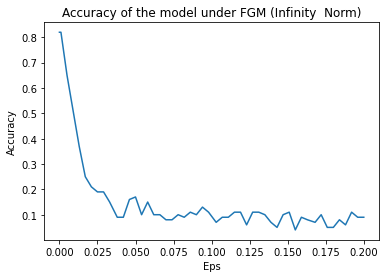

In [21]:
fgm_evaluate(model, x_test, y_test, np.inf, 0.001, 0.2, 50, 100)

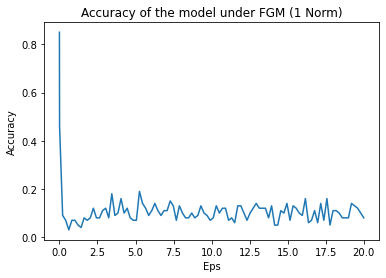

In [22]:
fgm_evaluate(model, x_test, y_test, 1, 0.01, 20, 100, 100)

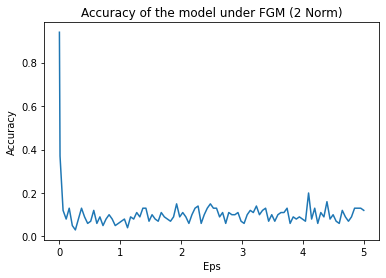

In [23]:
fgm_evaluate(model, x_test, y_test, 2, 0.01, 5, 100, 100)

## 4 - Adversarial Training

### 4.1 - Augmenting the training set with adversarial examples

In [31]:
adv_set_dim = int(( x_train.shape[0] / 100 ) * 40)
adv_set_dim

20000

#### 4.1.1 - Generating Adversarial samples for fixed epsilon (0.05)

In [32]:
# augment the training set for the adversarial model with fixed epsilon
x_adversarial_fixed, y_adversarial_fixed = next(generate_adversarials(model, x_train, y_train, adv_set_dim, eps=0.05))
x_fixed_train = np.concatenate((x_train, x_adversarial_fixed))
y_fixed_train = np.concatenate((y_train, y_adversarial_fixed))

#### 4.1.2 - Generating Adversarial samples for random epsilon

In [33]:
# augment the training set for the adversarial model with random epsilon
x_adversarial_random, y_adversarial_random = [], []
epsilons = list(np.linspace(0.001, 0.2, num=50))
for i in range(adv_set_dim):
    random_eps = random.choice(epsilons)
    x, y = next(generate_adversarials(model, x_train, y_train, 1, eps=random_eps))
    x_adversarial_random.append(x.reshape(32,32,3))
    y_adversarial_random.append(np.asarray(y[0]))
x_random_train = np.concatenate((x_train, x_adversarial_random))
y_random_train = np.concatenate((y_train, y_adversarial_random))

### 4.2 - Defining a Model and Training it with the new augmented dataset

In [60]:
def test_run(x_train, y_train, x_test, y_test, epochs=10, train_schedule=[1,1,1], start_lr=0.01, save=False, model_name="", load=False):

    if load == True:
        model = keras.models.load_model("models/" + model_name)
    
    else:
        model = define_model()
        
        for i in range(len(train_schedule)):
            learning_rate = start_lr / (2**i)
            phase_len = train_schedule[i]
        
            print("\nPhase " + str(i+1) + " - Learning rate: " + str(learning_rate))
            
            optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate, decay=1e-6)
            model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
            history = model.fit(x=x_train, y=y_train, epochs=phase_len*epochs, validation_data=(x_test,y_test), verbose=1)

        if save == True:
            file_name = "models/" + model_name
            model.save(file_name, include_optimizer=True)
            
    # Evaluate Models on clean test set
    model_accuracy = model.evaluate(x_test, y_test, batch_size=64, verbose=1)[1]
    print("\nAccuracy on clean test set: " +  '> %.3f' % (model_accuracy)) 
    
    # Evaluate Models on adversial patterns for differing epsilons
    accuracy_values = fgm_evaluate(model, x_test, y_test, np.inf, 0.001, 0.2, 50, 500, output=True)
    
    return model, accuracy_values

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_72 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_73 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 16, 16, 64)      

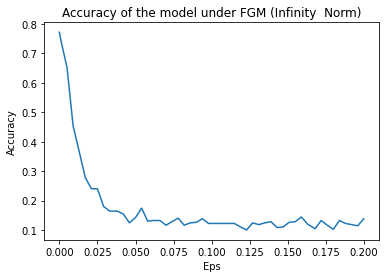

In [64]:
clean_model, clean_accuracy_values = test_run(x_train, y_train, x_test, y_test, epochs=15, save=True, model_name="clean_model_rms_3x15")
# clean_model, clean_accuracy_values = test_run(x_train, y_train, x_test, y_test, epochs=10, load=True, model_name="clean_model_1x10")

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_78 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_78 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_79 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 16, 16, 64)      

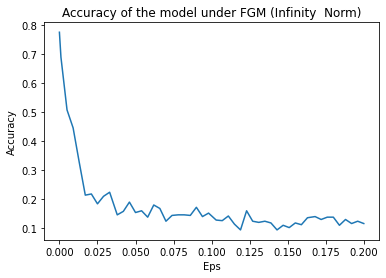

In [90]:
fixed_adv_model, fixed_accuracy_values = test_run(x_fixed_train, y_fixed_train, x_test, y_test, epochs=15, save=True, model_name="fixed_model_rms_3x15")
# fixed_adv_model, fixed_accuracy_values = test_run(x_fixed_train, y_fixed_train, x_test, y_test, epochs=10, load=True, model_name="fixed_model_1x10")

In [102]:
np.mean(fixed_accuracy_values[0:])

0.18282352972264385

In [103]:
np.mean(clean_accuracy_values[0:])

0.18152941237477696

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_84 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_84 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_85 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 16, 16, 64)      

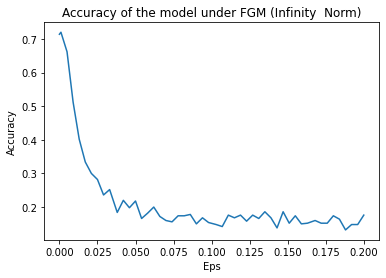

In [101]:
random_adv_model, random_accuracy_values = test_run(x_random_train, y_random_train, x_test, y_test, epochs=15, save=True, model_name="random_model_rms_3x15")
# random_adv_model, random_accuracy_values = test_run(x_random_train, y_random_train, x_test, y_test, epochs=10, load=True, model_name="random_model_1x10")

In [108]:
np.mean(random_accuracy_values[13])

0.21799999475479126

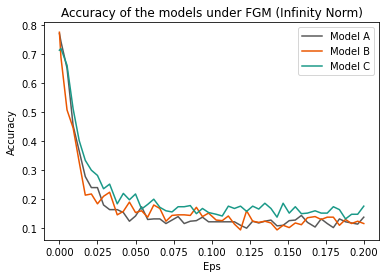

In [109]:
epsilons = list(np.linspace(0.001, 0.2, num=50))
epsilons.insert(0,0.)
epsilons = list(np.around(np.array(epsilons),3))
plt.plot(epsilons, clean_accuracy_values, color="#595959", label="Model A")
plt.plot(epsilons, fixed_accuracy_values, color="#eb5600", label="Model B")
plt.plot(epsilons, random_accuracy_values, color="#1a9988", label="Model C")
plt.title("Accuracy of the models under FGM (Infinity Norm)")
plt.xlabel("Eps")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## 5 - Adversarial Attack with Projected Gradient Descent Method

In [13]:
def pgdm_comparison(model, clean_image, eps=0.05, norm=np.inf, eps_iter=0.01, nb_iter=40, show=True, save=False):
    
    clean_image, clean_image_class, clean_image_confidence = predict_class(model, clean_image, show=False)
    
    adv_example = projected_gradient_descent(model, clean_image.reshape(-1, 32, 32, 3), eps, eps_iter, nb_iter, norm)
    adv_example_image, adv_example_class, adv_example_confidence = predict_class(model, adv_example, show=False)
    adv_example_image = adv_example_image.clip(0.,1)
    
    adv_noise = (adv_example_image - clean_image)* 0.5 + 0.5 
    
    if norm == np.inf:
        norm = "inf"
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 10))
    fig.suptitle("Projected Gradient Descent Method (eps=" + str(eps) + ", norm=" + str(norm) + ")", y=0.66, fontsize="x-large", ha="center")
    
    ax1.imshow(clean_image)
    ax1.set_title("Original Image Classification")
    ax1.set_xlabel(clean_image_class + ": " + str(clean_image_confidence))
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    ax2.imshow(adv_noise)
    ax2.set_title("Adversarial Noise")
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    ax3.imshow(adv_example_image)
    ax3.set_title("Adversarial Example")
    ax3.set_xlabel(adv_example_class + ": " + str(adv_example_confidence))
    ax3.set_xticks([])
    ax3.set_yticks([])
    
    if save == True:
        if norm == np.inf:
            image_name = clean_image_class + "_inf_" + str(eps) + ".png"
        else:
            image_name = clean_image_class + "_" + str(norm) + "_" + str(eps) + ".png"
        plt.savefig('images/' + image_name)
        plt.close()
     
    if show == True:
        plt.show() 

### 3.1 - Testing on single images for fixed epsilon (0.05)

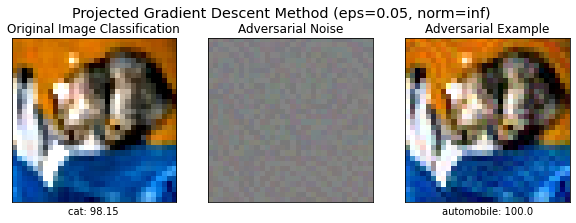

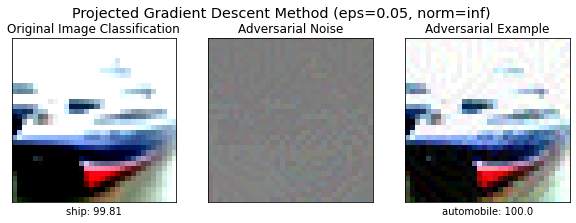

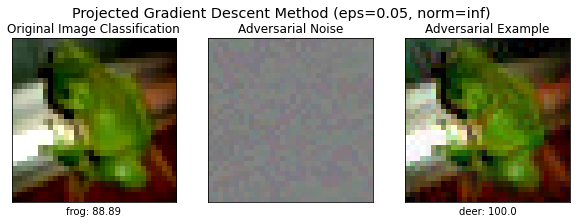

In [14]:
for i in [0, 1, 7]:
    pgdm_comparison(model, x_test[i], eps=0.05, norm=np.inf)

### 3.2 - Testing on single images for differing values of epsilon

#### 3.2.1 - Frog test

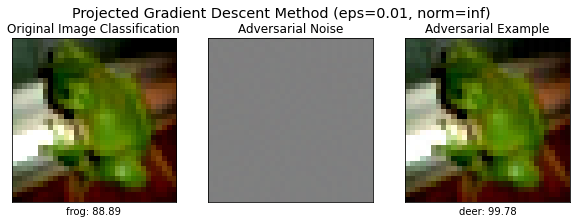

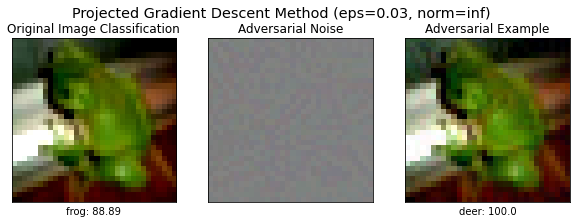

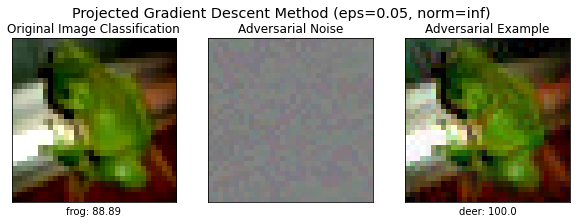

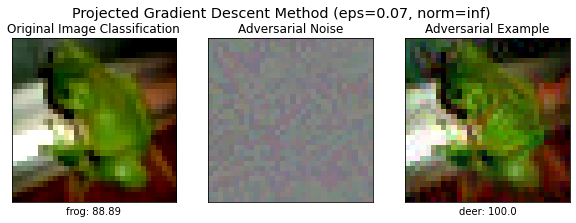

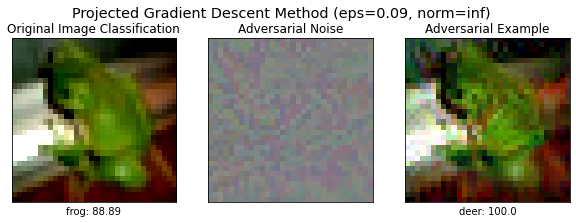

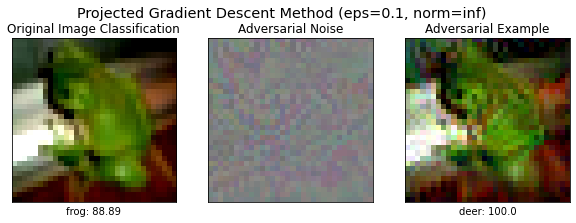

In [15]:
frog_image = x_test[7]
epsilons = [0.01, 0.03, 0.05, 0.07, 0.09, 0.1]
for eps in epsilons:
    pgdm_comparison(model, frog_image, eps)

#### 3.2.2 - Boat test

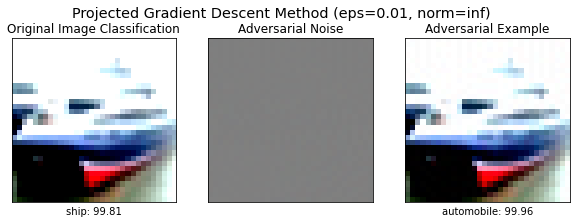

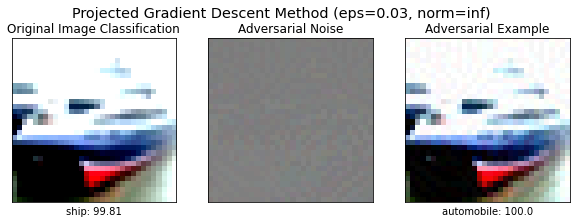

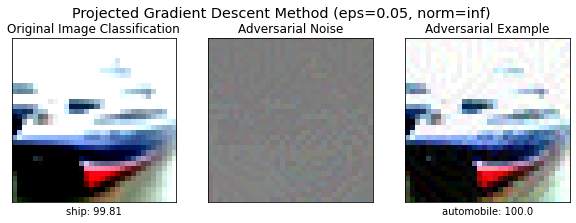

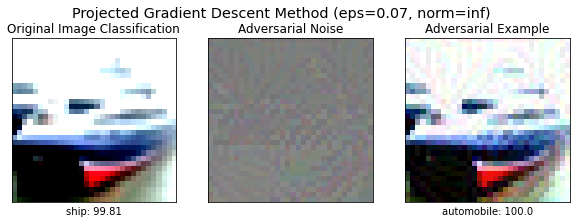

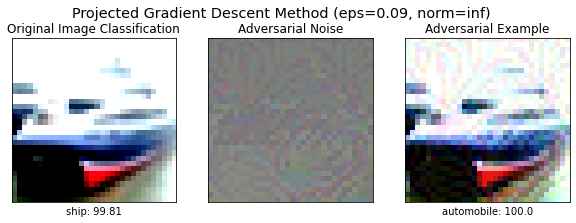

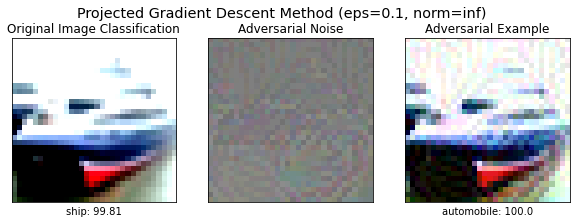

In [16]:
boat_image = x_test[1]
epsilons = [0.01,0.03, 0.05, 0.07, 0.09, 0.1]
for eps in epsilons:
    pgdm_comparison(model, boat_image, eps)

#### 3.2.3 - Save images for differing epsilons and norms

In [20]:
def pgdm_PNG_per_GIF(model, clean_image, eps=0.05, norm=np.inf, eps_iter=0.01, nb_iter=40):
    
    clean_image, clean_image_class, clean_image_confidence = predict_class(model, clean_image, show=False)
    
    adv_example = projected_gradient_descent(model, clean_image.reshape(-1, 32, 32, 3), eps, eps_iter, nb_iter, norm)
    adv_example_image, adv_example_class, adv_example_confidence = predict_class(model, adv_example, show=False)
    adv_example_image = adv_example_image.clip(0.,1)
    
    if adv_example_class != clean_image_class:
        label_color = "red"
    elif adv_example_confidence < clean_image_confidence:
        label_color = "orange"
    else:
        label_color = "green"
    
    adv_noise = (adv_example_image - clean_image)* 0.5 + 0.5 
    
    if norm == np.inf:
        text_norm = "Infinity "
    else:
        text_norm = norm
    
    fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(10, 10))
    #fig.suptitle("FGM: eps = " + str(eps) + ", norm = " + str(norm), y=0.96, fontsize="x-large", ha="center", fontweight='bold')
    
    ax2.imshow(adv_noise)
    ax2.set_title("Adversarial Noise", fontsize="x-large", fontweight='bold')
    ax2.set_xlabel("PGDM (" + str(text_norm) + " Norm): eps = " + str(eps), fontsize="x-large", fontweight='bold')
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    ax3.imshow(adv_example_image)
    ax3.set_title("Adversarial Example", fontsize="x-large", fontweight='bold')
    ax3.set_xlabel(adv_example_class + ": " + str(adv_example_confidence), fontsize="x-large", c=label_color, fontweight='bold')
    ax3.set_xticks([])
    ax3.set_yticks([])

    if norm == np.inf:
        image_name = clean_image_class + "_inf_" + str(eps) + ".png"
    else:
        image_name = clean_image_class + "_" + str(norm) + "_" + str(eps) + ".png"
    plt.savefig('images/' + image_name)
    plt.close()

In [23]:
def pgdm_GIF(model, clean_image, norm, image_name="image", eps_start=0.001, eps_end=0.2, eps_num=100):
    epsilons = list(np.linspace(eps_start, eps_end, num=eps_num))
    #epsilons.insert(0,0.)
    epsilons = list(np.around(np.array(epsilons),3))
    for eps in epsilons:
        pgdm_PNG_per_GIF(model, clean_image, eps, norm=norm)
        
    if norm == np.inf:
        text_norm = "inf"
    else:
        text_norm = str(norm)
        
    fp_in = "images/" + image_name + "_" + text_norm + "_*.png"
    fp_out = "images/" + image_name + "_pgdm_" + text_norm + ".gif"

    img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
    img.save(fp=fp_out, format='GIF', append_images=imgs,
             save_all=True, duration=200, loop=0)

In [27]:
pgdm_GIF(model, frog_image, np.inf, "frog", 0.011, 0.1, 10)
# fgm_GIF(model, boat_image, 1, "ship", 0.01, 20, 100)
# fgm_GIF(model, frog_image, 2, "frog", 0.01, 3, 50)

### 3.3 - Evaluating the model on sets of adversarial examples for varying epsilon

In [31]:
def pgdm_generate_adversarials(model, x, y, dataset_dim, eps=0.05, norm=np.inf, eps_iter=0.01, nb_iter=40):
    while True:
        new_x = []
        new_y = []
        for element in range(dataset_dim):         
            N = random.randint(0, x.shape[0] - 1)

            label = y[N]
            image = x[N]
            
            adversarial = projected_gradient_descent(model, image.reshape(-1, 32, 32, 3), eps, eps_iter, nb_iter, norm).reshape(32,32,3)
            
            new_x.append(adversarial)
            new_y.append(y[N])
        
        new_x = np.asarray(new_x).reshape((dataset_dim, 32, 32, 3))
        new_y = np.asarray(new_y)
        
        yield new_x, new_y

In [32]:
# crafting the set containing the adversarial samples
# x_adv_test, y_adv_test = next(generate_adversarials(model, x_test, y_test, 1000))

# adv_accuracy = model.evaluate(x_adv_test, y_adv_test, batch_size=64, verbose=0)[1]
# print("\nAccuracy on the \"adversarial\" set: " +  '> %.3f' % (adv_accuracy)) 

In [33]:
def pgdm_evaluate(model, x_test, y_test, norm, eps_start=0.001, eps_end=0.2, eps_num=100, adv_test_set_dim=100, output=False):
    epsilons = list(np.linspace(eps_start, eps_end, num=eps_num))
    epsilons = list(np.around(np.array(epsilons),3))
    
    adv_accuracy_values = []
    
    for eps in epsilons:
        # crafting the set containing the adversarial samples
        x_adv_test, y_adv_test = next(pgdm_generate_adversarials(model, x_test, y_test, adv_test_set_dim, eps=eps))

        adv_accuracy = model.evaluate(x_adv_test, y_adv_test, batch_size=64, verbose=0)[1]
        adv_accuracy_values.append(adv_accuracy)

    if norm == np.inf:
        text_norm = "Infinity "
    else:
        text_norm = norm
        
    plt.plot(epsilons, adv_accuracy_values)
    plt.title("Accuracy of the model under PGDM (" + str(text_norm) + " Norm)")
    plt.xlabel("Eps")
    plt.ylabel("Accuracy")
    plt.show()
    
    if output == True:
        return adv_accuracy_values

In [34]:
pgdm_evaluate(model, x_test, y_test, np.inf, 0.011, 0.5, 50, 100)

KeyboardInterrupt: 

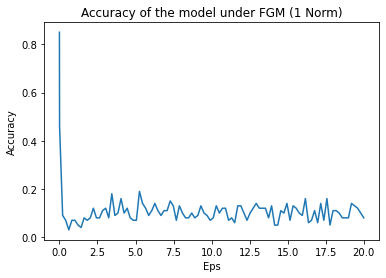

In [22]:
fgm_evaluate(model, x_test, y_test, 1, 0.01, 20, 100, 100)

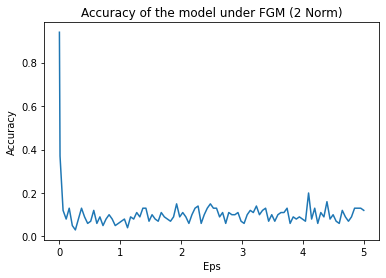

In [23]:
fgm_evaluate(model, x_test, y_test, 2, 0.01, 5, 100, 100)

## 6 - Adversarial Attack with Carlini Wagner Attack

In [37]:
def cw_comparison(model, clean_image, show=True, save=False):
    
    clean_image, clean_image_class, clean_image_confidence = predict_class(model, clean_image, show=False)
    
    adv_example = carlini_wagner_l2(model, clean_image.reshape(-1, 32, 32, 3))
    adv_example_image, adv_example_class, adv_example_confidence = predict_class(model, adv_example, show=False)
    adv_example_image = adv_example_image.clip(0.,1)
    
    adv_noise = (adv_example_image - clean_image)* 0.5 + 0.5 
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 10))
    fig.suptitle("Carlini Wagner L2" , y=0.66, fontsize="x-large", ha="center")
    
    ax1.imshow(clean_image)
    ax1.set_title("Original Image Classification")
    ax1.set_xlabel(clean_image_class + ": " + str(clean_image_confidence))
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    ax2.imshow(adv_noise)
    ax2.set_title("Adversarial Noise")
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    ax3.imshow(adv_example_image)
    ax3.set_title("Adversarial Example")
    ax3.set_xlabel(adv_example_class + ": " + str(adv_example_confidence))
    ax3.set_xticks([])
    ax3.set_yticks([])
    
    if save == True:
        if norm == np.inf:
            image_name = clean_image_class + ".png"
        else:
            image_name = clean_image_class + ".png"
        plt.savefig('images/' + image_name)
        plt.close()
     
    if show == True:
        plt.show() 

### 3.1 - Testing on single images for fixed epsilon (0.05)

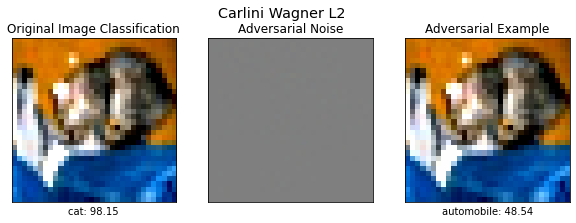

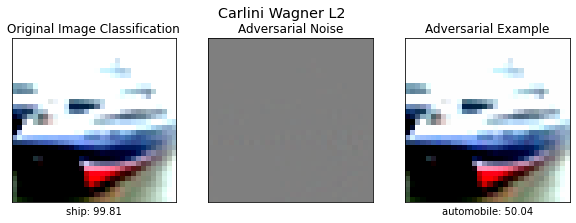

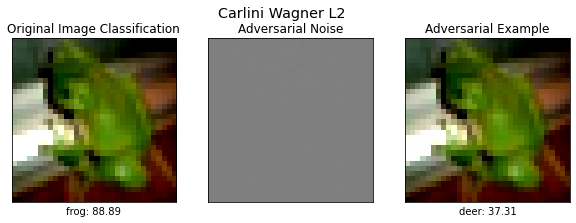

In [38]:
for i in [0, 1, 7]:
    cw_comparison(model, x_test[i])

#### 3.2.3 - Save images for differing epsilons and norms

In [51]:
def cw_PNG_per_GIF(model, clean_image):
    
    clean_image, clean_image_class, clean_image_confidence = predict_class(model, clean_image, show=False)
    
    adv_example = carlini_wagner_l2(model, clean_image.reshape(-1, 32, 32, 3))
    adv_example_image, adv_example_class, adv_example_confidence = predict_class(model, adv_example, show=False)
    adv_example_image = adv_example_image.clip(0.,1)
    
    if adv_example_class != clean_image_class:
        label_color = "red"
    elif adv_example_confidence < clean_image_confidence:
        label_color = "orange"
    else:
        label_color = "green"
    
    adv_noise = (adv_example_image - clean_image)* 0.5 + 0.5 
    
    fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(10, 10))
    
    ax2.imshow(adv_noise)
    ax2.set_title("Adversarial Noise", fontsize="x-large", fontweight='bold')
    ax2.set_xlabel("Carlini Wagner L2", fontsize="x-large", fontweight='bold')
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    ax3.imshow(adv_example_image)
    ax3.set_title("Adversarial Example", fontsize="x-large", fontweight='bold')
    ax3.set_xlabel(adv_example_class + ": " + str(adv_example_confidence), fontsize="x-large", c=label_color, fontweight='bold')
    ax3.set_xticks([])
    ax3.set_yticks([])
    image_name = clean_image_class + ".png"
    plt.savefig('images/' + image_name)
    plt.close()

In [48]:
def cw_GIF(model, clean_image, image_name="image"):
    pgdm_PNG_per_GIF(model, clean_image)
        
    fp_in = "images/" + image_name + "_*.png"
    fp_out = "images/" + image_name + "_cw_" +".gif"

    img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
    img.save(fp=fp_out, format='GIF', append_images=imgs,
             save_all=True, duration=200, loop=0)

In [52]:
cw_PNG_per_GIF(model, frog_image)

#cw_GIF(model, frog_image)
# fgm_GIF(model, boat_image, 1, "ship", 0.01, 20, 100)
# fgm_GIF(model, frog_image, 2, "frog", 0.01, 3, 50)